In [1]:
import pickle
import matplotlib.pyplot as plt
import numpy as np
import imageio
import glob
import cv2
import skimage
from imageio import imread
import csv
import math
import ktrain
from keras_lr_finder import LRFinder

# Creating a generator to load and preprocess the images

In [2]:
train_csv_path = "/home/houcem/data/data.csv"
val_csv_path = "/home/houcem/data_val/data.csv"
train_sample_size = sum(1 for row in open(train_csv_path))
val_sample_size = sum(1 for row in open(val_csv_path))

In [3]:
batch_size = 32

In [4]:
def generator(csv_path, batch_size):
    X_train = []
    y_train = []
    batchcount = 0
    
    while True: #Keeping the generator running
        with open(csv_path) as f:
            next(f) #Skipping the header
            for line in f:
                img_x_path, throttle, steering_angle, img_y_path = line.split(',')
                
                #Loading and Normalizing the input frame
                img_x = imread(str(img_x_path))
                img_x = img_x/255.0
                
                #Packing the motor input into a numpy array
                motor_input = np.asarray([throttle, steering_angle])
                
                #Loading and Normalizing the target frame
                #img_y = cv2.imread(img_y_path.rstrip("\n"))
                #img_y = img_y/255.0
                
                #Packing and adding the inputs and targets into the batch
                X_train.append(img_x)
                y_train.append(img_x)
                   
                batchcount += 1    
                    
                if batchcount == batch_size:
                    X_train = np.asarray(X_train)
                    y_train = np.asarray(y_train)
                    yield(X_train, y_train)
                    X_train = []
                    y_train = []
                    batchcount = 0

In [5]:
def babbling_generator(csv_path, batch_size):
    X_train = []
    y_train = []
    motor_train = []
    batchcount = 0
    
    while True: #Keeping the generator running
        with open(csv_path) as f:
            next(f) #Skipping the header
            for line in f:
                img_x_path, throttle, steering_angle, img_y_path = line.split(',')
                
                #Loading and Normalizing the input frame
                img_x = imread(str(img_x_path))
                img_x = img_x/255.0
                
                #Packing the motor input into a numpy array
                motor_input = np.asarray([float(throttle), float(steering_angle)])
                
                #Loading and Normalizing the target frame
                img_y = cv2.imread(str(img_y_path).rstrip("\n"))
                img_y = img_y/255.0
                
                #Packing and adding the inputs and targets into the batch
                X_train.append(img_x)
                motor_train.append(motor_input)
                y_train.append(img_y)
                   
                batchcount += 1    
                    
                if batchcount == batch_size:
                    X_train = np.asarray(X_train)
                    motor_train = np.asarray(motor_train)                    
                    y_train = np.asarray(y_train)
                    yield([X_train, motor_train], y_train)
                    X_train = []
                    y_train = []
                    motor_train = []
                    batchcount = 0

# Defining the model

In [16]:
from tensorflow import keras
import tensorflow as tf
from keras import layers
#tf.config.experimental_run_functions_eagerly(True)
#tf.compat.v1.disable_eager_execution()

In [17]:
from keras.layers import Lambda, Conv2D, Conv2DTranspose, Dense, Input, Flatten, Concatenate, Reshape, BatchNormalization, Dropout, MaxPooling2D, UpSampling2D, GaussianNoise
from keras.activations import relu, linear
from keras import Model
from keras.callbacks import Callback, ReduceLROnPlateau,EarlyStopping
from keras import backend as K
from keras.losses import binary_crossentropy

In [18]:
image_input = Input(shape=(112,112,3))
x = Conv2D(8, (3,3), activation = 'relu', padding = 'same')(image_input)
x = MaxPooling2D()(x)
x = Conv2D(16, (3,3), activation = 'relu', padding = 'same')(x)
x = MaxPooling2D()(x)
x = Conv2D(32, (3,3), activation = 'relu', padding = 'same')(x)
x = MaxPooling2D()(x)
x = Conv2D(64, (3,3), activation = 'relu', padding = 'same')(x)
x = MaxPooling2D()(x)
x = Flatten()(x)

z = Dense(49, activation ='relu')(x)

encoder = Model(inputs= [image_input], outputs = [z])

encoder.summary()

Model: "model_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_4 (InputLayer)         [(None, 112, 112, 3)]     0         
_________________________________________________________________
conv2d_9 (Conv2D)            (None, 112, 112, 8)       224       
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 56, 56, 8)         0         
_________________________________________________________________
conv2d_10 (Conv2D)           (None, 56, 56, 16)        1168      
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 28, 28, 16)        0         
_________________________________________________________________
conv2d_11 (Conv2D)           (None, 28, 28, 32)        4640      
_________________________________________________________________
max_pooling2d_6 (MaxPooling2 (None, 14, 14, 32)        0   

In [19]:
input_decoder = Input(shape=(49,))

d = Dense(3136, activation = 'relu')(input_decoder)
d = Reshape((7,7,64))(d)
d = UpSampling2D()(d)
d = Conv2D(64,(3, 3), strides=1, activation='relu', padding='same')(d)
d = UpSampling2D()(d)
d = Conv2D(32,(3, 3), strides=1, activation='relu', padding='same')(d)
d = UpSampling2D()(d)
d = Conv2D(16,(3, 3), strides=1, activation='relu', padding='same')(d)
d = UpSampling2D()(d)
d = Conv2D(8,(3, 3), strides=1, activation='relu', padding='same')(d)
decoded = Conv2D(3, (3, 3), strides = 1, activation='relu', padding='same')(d)

Decoder = Model(inputs = input_decoder, outputs = decoded)

In [20]:
Decoder.summary()

Model: "model_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_5 (InputLayer)         [(None, 49)]              0         
_________________________________________________________________
dense_3 (Dense)              (None, 3136)              156800    
_________________________________________________________________
reshape_1 (Reshape)          (None, 7, 7, 64)          0         
_________________________________________________________________
up_sampling2d_4 (UpSampling2 (None, 14, 14, 64)        0         
_________________________________________________________________
conv2d_13 (Conv2D)           (None, 14, 14, 64)        36928     
_________________________________________________________________
up_sampling2d_5 (UpSampling2 (None, 28, 28, 64)        0         
_________________________________________________________________
conv2d_14 (Conv2D)           (None, 28, 28, 32)        1846

# Creating the autoencoder

In [21]:
img_input = Input(shape=(112, 112, 3))
Encoded = encoder([img_input])
Noise = GaussianNoise(0.3)(Encoded)
Decoded = Decoder(Noise)

autoencoder = Model(inputs = [img_input], outputs = Decoded)

In [22]:
autoencoder.summary()

Model: "model_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_6 (InputLayer)         [(None, 112, 112, 3)]     0         
_________________________________________________________________
model_3 (Model)              (None, 49)                178241    
_________________________________________________________________
gaussian_noise_1 (GaussianNo (None, 49)                0         
_________________________________________________________________
model_4 (Model)              (None, 112, 112, 3)       218195    
Total params: 396,436
Trainable params: 396,436
Non-trainable params: 0
_________________________________________________________________


# Autoencoder training

In [23]:
autoencoder.compile(loss = 'mse', optimizer= keras.optimizers.Adam()) #previous learning rate is 10e-4

In [14]:
autoencoder.fit(generator(train_csv_path, batch_size), steps_per_epoch = train_sample_size/batch_size, epochs = 0, validation_data=generator(val_csv_path, batch_size), validation_steps=val_sample_size/batch_size)

Epoch 1/20
1563/1562 [==============================] - 102s 65ms/step - loss: 0.0164 - val_loss: 0.0100
Epoch 2/20
1563/1562 [==============================] - 61s 39ms/step - loss: 0.0088 - val_loss: 0.0078
Epoch 3/20
1563/1562 [==============================] - 59s 38ms/step - loss: 0.0078 - val_loss: 0.0074
Epoch 4/20
1563/1562 [==============================] - 59s 38ms/step - loss: 0.0078 - val_loss: 0.0096
Epoch 5/20
1563/1562 [==============================] - 60s 39ms/step - loss: 0.0084 - val_loss: 0.0075
Epoch 6/20
1563/1562 [==============================] - 62s 39ms/step - loss: 0.0074 - val_loss: 0.0072
Epoch 7/20
1563/1562 [==============================] - 58s 37ms/step - loss: 0.0071 - val_loss: 0.0070
Epoch 8/20
1563/1562 [==============================] - 57s 37ms/step - loss: 0.0070 - val_loss: 0.0068
Epoch 9/20
1563/1562 [==============================] - 57s 37ms/step - loss: 0.0069 - val_loss: 0.0067
Epoch 10/20
1563/1562 [==============================] - 58s 37

In [15]:
autoencoder.save_weights("autoencoder_upsampling_noisy.h5")

# Let's check out the prediction for the first image

In [25]:
csv_file = open(train_csv_path)
next(csv_file)

'img_x,throttle,steer,img_y\n'

In [26]:
img_x_path, throttle, steering_angle, img_y_path = next(csv_file).split(',')

In [27]:
showed_image = imread(img_x_path)

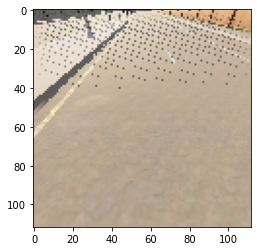

In [28]:
plt.imshow(showed_image)

In [29]:
img = imread(img_x_path)
img = img/255.0
img = img.reshape([1,112,112,3])

In [30]:
result = autoencoder.predict(img)

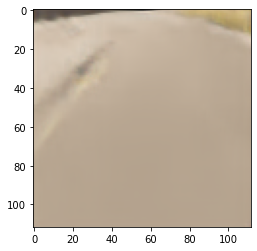

In [31]:
plt.imshow(result.reshape([112,112,3]))

# Building the motor babbling MLP

In [24]:
autoencoder.load_weights('autoencoder_upsampling_noisy.h5') 

In [32]:
autoencoder.trainable = False

In [33]:
latent_input = Input(shape=(49,))

motor_input = Input(shape=(2,))

babbling_input = Concatenate()([latent_input, motor_input])

z = Dense(512, activation = 'relu')(babbling_input)
z = Dense(49, activation = 'relu')(z)

babbling_mlp = Model(inputs = [latent_input, motor_input], outputs = z)

In [34]:
babbling_mlp.summary()

Model: "model_6"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_7 (InputLayer)            [(None, 49)]         0                                            
__________________________________________________________________________________________________
input_8 (InputLayer)            [(None, 2)]          0                                            
__________________________________________________________________________________________________
concatenate (Concatenate)       (None, 51)           0           input_7[0][0]                    
                                                                 input_8[0][0]                    
__________________________________________________________________________________________________
dense_4 (Dense)                 (None, 512)          26624       concatenate[0][0]          

In [35]:
img_input = Input(shape=(112, 112, 3), name = "img")
motor_input = Input(shape=(2,), name = "motor")

Encoded = encoder([img_input])
babbling = babbling_mlp([Encoded, motor_input])
Decoded = Decoder(babbling)

babbling_model = Model(inputs = [img_input, motor_input], outputs = Decoded)

In [36]:
babbling_model.summary()

Model: "model_7"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
img (InputLayer)                [(None, 112, 112, 3) 0                                            
__________________________________________________________________________________________________
model_3 (Model)                 (None, 49)           178241      img[0][0]                        
__________________________________________________________________________________________________
motor (InputLayer)              [(None, 2)]          0                                            
__________________________________________________________________________________________________
model_6 (Model)                 (None, 49)           51761       model_3[2][0]                    
                                                                 motor[0][0]                

In [37]:
babbling_model.compile(loss = 'mse', optimizer = keras.optimizers.Adam(learning_rate=0.00007))

In [38]:
batch_size = 32

In [ ]:
babbling_model.fit(babbling_generator(train_csv_path, batch_size), steps_per_epoch = train_sample_size/batch_size, epochs = 10, validation_data=babbling_generator(val_csv_path, batch_size), validation_steps= val_sample_size/batch_size)

Epoch 1/10
1563/1562 [==============================] - 82s 52ms/step - loss: 0.0244 - val_loss: 0.0228
Epoch 2/10
1563/1562 [==============================] - 82s 53ms/step - loss: 0.0233 - val_loss: 0.0222
Epoch 3/10
1563/1562 [==============================] - 82s 53ms/step - loss: 0.0231 - val_loss: 0.0220
Epoch 4/10
1563/1562 [==============================] - 80s 51ms/step - loss: 0.0230 - val_loss: 0.0219
Epoch 5/10
1563/1562 [==============================] - 79s 51ms/step - loss: 0.0229 - val_loss: 0.0219
Epoch 6/10
1563/1562 [==============================] - 80s 51ms/step - loss: 0.0229 - val_loss: 0.0218
Epoch 7/10
1563/1562 [==============================] - 80s 51ms/step - loss: 0.0229 - val_loss: 0.0218
Epoch 8/10
1563/1562 [==============================] - 82s 52ms/step - loss: 0.0229 - val_loss: 0.0218
Epoch 9/10
 501/1562 [========>.....................] - ETA: 45s - loss: 0.0231

# Let's see what the output looks like

In [97]:
csv_file = open(train_csv_path)
next(csv_file)

'img_x,throttle,steer,img_y\n'

In [147]:
img_x_path, throttle, steering_angle, img_y_path = next(csv_file).split(',')

In [150]:
motor_input = np.asarray([float(throttle), float(steering_angle)])

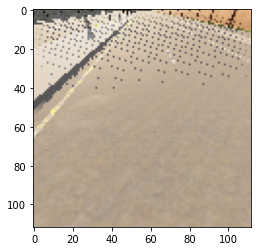

In [151]:
showed_image = imread(img_x_path)
plt.imshow(showed_image)

In [155]:
img = imread(img_x_path)
img = img/255.0

In [156]:
babbling_model.predict()

ValueError: Data cardinality is ambiguous:
  x sizes: 112, 2
Please provide data which shares the same first dimension.